In [45]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.models as models

# Downloading the Data

In [46]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

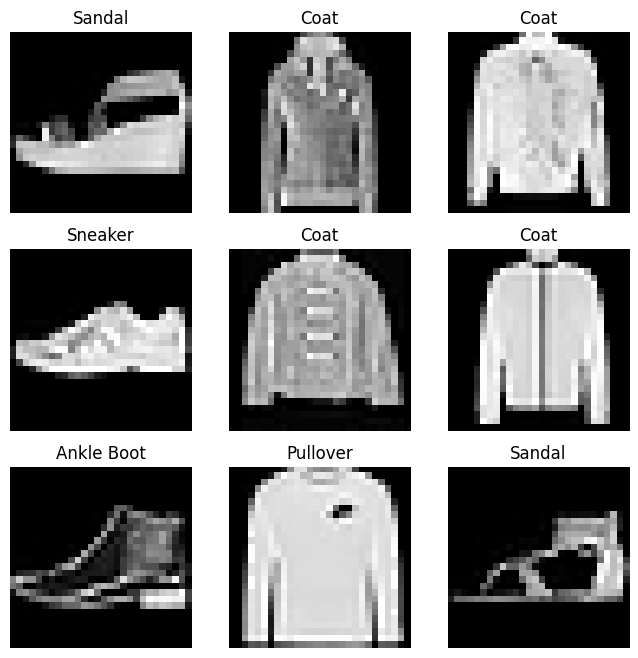

In [47]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating the Model

In [48]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    y = self.linear_relu_stack(x)
    return y


In [49]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Train and Test

In [50]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    prediction = model(X)
    loss = loss_fn(prediction, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      prediction = model(X)
      test_loss += loss_fn(prediction, y).item()
      correct += (prediction.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [51]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [52]:
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  save_checkpoint({"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()})
  test(test_dataloader, model, loss_fn)


Epoch 1
-------------------------------
loss: 2.311153  [   64/60000]
loss: 2.287192  [ 6464/60000]
loss: 2.277086  [12864/60000]
loss: 2.267758  [19264/60000]
loss: 2.251398  [25664/60000]
loss: 2.231191  [32064/60000]
loss: 2.219168  [38464/60000]
loss: 2.195114  [44864/60000]
loss: 2.162099  [51264/60000]
loss: 2.169413  [57664/60000]
=> Saving checkpoint
Test Error: 
 Accuracy: 55.1%, Avg loss: 2.158784 

Epoch 2
-------------------------------
loss: 2.182857  [   64/60000]
loss: 2.140838  [ 6464/60000]
loss: 2.077681  [12864/60000]
loss: 2.126445  [19264/60000]
loss: 2.070286  [25664/60000]
loss: 2.011912  [32064/60000]
loss: 1.982067  [38464/60000]
loss: 1.937263  [44864/60000]
loss: 1.970579  [51264/60000]
loss: 1.899992  [57664/60000]
=> Saving checkpoint
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.882401 

Epoch 3
-------------------------------
loss: 1.850698  [   64/60000]
loss: 1.883768  [ 6464/60000]
loss: 1.705001  [12864/60000]
loss: 1.688212  [19264/60000]
loss: 1.770360

In [56]:
model2 = NeuralNetwork()
load_checkpoint(torch.load('my_checkpoint.pth'), model2)
test(test_dataloader, model, loss_fn)

=> Loading checkpoint
Test Error: 
 Accuracy: 64.1%, Avg loss: 1.084854 

